<a href="https://colab.research.google.com/github/Quantum-SMC/quantum_smc/blob/main/quantum_smc_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation requirements

In [18]:
!pip install qiskit
!pip install qiskit[visualization]
!pip install qiskit-aer

from qiskit import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from qiskit import transpile, assemble
from qiskit.visualization import *

from math import sqrt, pi, exp
from qiskit import Aer, execute
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.visualization import plot_bloch_vector
from qiskit.result import marginal_counts

Implementation of a new Secure Multipary Computation (SMC) protocol to compute symmetric Boolean functions of degree 2.

In the following the OR function of Alice's and Bob's private input is computed.

In [36]:
# Private inputs of Alice and Bob
a1 = 1
a2 = 1
b1 = 1
b2 = 1
r = [1, 1, 1, 1]  # random bits that are shared between Alice and Bob.

In [37]:
# Polynomials to compute OR fuction
P = [
    a1&a2,
    a1^(a1&a2),
    1^a1^a2^(a1&a2),
    a1^(a1&a2)
]
Q = [
    1,
    b2,
    b1&b2,
    b1
]

In [30]:
# constants
counts_list = []
colors = ['r', 'g', 'b', 'y']

In [42]:
# New SMC protocol to compute Boolean functions of degree 2
for i in range(0, 4):
    # Create a quantum circuit
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    qc = QuantumCircuit(q, c)

    # GHZ state preparation
    qc.barrier()
    qc.h(q[0])
    qc.cx(q[0],q[1])
    qc.cx(q[1],q[2])
    qc.z(q[2])
    qc.x(q[2])
    qc.barrier()

    # Apply rz rotation on the fisrt qubit if r = 1
    if r[i] == 1:
      qc.rz(pi, q[0])

    #qc.rz(pi, q[0]).c_if(r[i], 1)

    # Apply rzdg rotation on the fisrt qubit if P[i] == 1
    if P[i] == 1:
        qc.rz(-pi/2, q[0])
    #qc.rz(-pi/2, q[0]).c_if(P[i], 1)

    # Apply rzdg rotation on the fisrt qubit if Q[i] == 1
    if Q[i] == 1:
        qc.rz(-pi/2, q[1])
    #qc.rz(-pi/2, q[1]).c_if(Q[i], 1)

    # Apply rzdg rotation on the fisrt qubit if (P[i] ^ Q[i]) == 1
    if (P[i]^Q[i]) == 1:
        qc.rz(-pi/2, q[2])
    #qc.rz(-pi/2, q[2]).c_if((P[i]^Q[i]), 1)

    # Apply Hadamard gates for X basis measurement
    qc.barrier()
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[2])

    # Perform measurement
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])
    qc.measure(q[2], c[2])

    #visualization
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result().get_counts()
    print(result)
    counts_list.append(result)
    #plot_histogram(result).savefig(f'histogram_iteration_{i}.png')

#    ploting bloch sphere for all qubits
#    qc.save_statevector()
#    state = backend.run(qc).result().get_statevector()
#    plot_bloch_multivector(state)

    # Extract the XOR result from classical register
    c_values = [int(bit) for bit in list(result.keys())[0]]
    print("The XOR of the three measurement outcomes in round", i, "is: ", c_values[0] ^ c_values[1] ^ c_values[2])



{'001': 248, '111': 257, '100': 235, '010': 260}
The XOR of the three measurement outcomes in round 0 is:  1
{'011': 250, '000': 248, '101': 261, '110': 241}
The XOR of the three measurement outcomes in round 1 is:  0
{'110': 256, '000': 249, '101': 260, '011': 235}
The XOR of the three measurement outcomes in round 2 is:  0
{'110': 270, '011': 245, '000': 233, '101': 252}
The XOR of the three measurement outcomes in round 3 is:  0


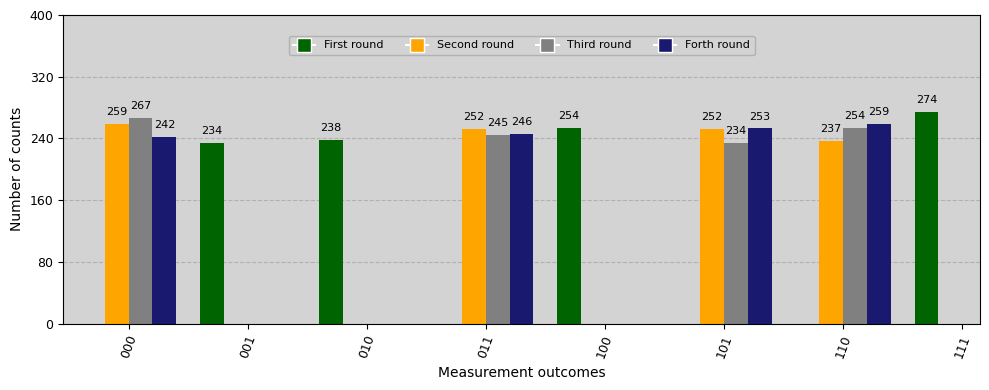

In [35]:
# Visualization of all rounds in a single diagram
# Create a new matplotlib figure and Axes object
fig, ax = plt.subplots(figsize=(10, 4))


legends = ['First round', 'Second round', 'Third round', 'Forth round']
colors=['darkgreen', 'orange', 'gray', 'midnightblue']
plot_histogram(counts_list, figsize=(10, 4), color=colors, bar_labels=False, ax=ax)

plt.xlabel("Measurement outcomes", fontsize=10)
plt.ylabel("Number of counts", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Customizing the legend
legend_labels = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in colors]
legend = plt.legend(legend_labels, legends, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(legends) , fontsize=8)
# Increase the y-axis limit
ax.set_ylim(0, 400)  # Set the desired limit here

# Set the background color
ax.set_facecolor('#D3D3D3')

# Set the background color of the legend
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('darkgray')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(height, (rect.get_x() + rect.get_width() / 2, height),
                ha='center', va='bottom', fontsize=8,
                xytext=(0, 5), textcoords='offset points')

# Adjust the positioning of the plot within the figure
plt.tight_layout()
plt.savefig('histogram.png')

#my_gate_names = {
#    "displaytext": {
        # gate name : gate text to be displayed
#        "rz": "U"
#    },
#}
#qc.draw('mpl', style=my_gate_names)